<a href="https://colab.research.google.com/github/NandakumarGunalan/MLLaboratory/blob/main/Clec2_cross_validation_confidence_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross Validation and confidence intervals
In this notebook we will practice cross-validation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import r2_score

## Data description

1. Title: Auto-Mpg Data

2. Sources:
   
   * Origin:  This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.
   * Date: July 7, 1993

3. Past Usage:
    *  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed
   because they had unknown values for the "mpg" attribute.  The original
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

5. Number of Instances:

      	398

6. Number of Attributes: 9 including the class attribute

7. Attribute Information:

    * mpg:           continuous
    * cylinders:     multi-valued discrete
    * displacement:  continuous
    * horsepower:    continuous
    * weight:        continuous
    * acceleration:  continuous
    * model year:    multi-valued discrete
    * origin:        multi-valued discrete
    * car name:      string (unique for each instance)

8. Missing Attribute Values:

    * horsepower has 6 missing values



Summary: This dataset is used to predict a car’s fuel efficiency (mpg) based on features like cylinders, horsepower, weight, and model year. It’s a mix of continuous and categorical attributes, with a few missing values to handle.

## Get data

[Link to auto data](https://archive.ics.uci.edu/dataset/9/auto+mpg)

In [ ]:
# Run only once to unstall UCI ML Repo package. # ucimlrepo is a library that lets you easily access datasets from the UCI Machine Learning Repository directly in Python
%pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id = 9)

# data (as pandas dataframes)
auto = pd.concat([auto_mpg.data.features, auto_mpg.data.targets], axis = 1)

auto.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


In [ ]:
type(auto_mpg)

ucimlrepo.dotdict.dotdict

In [ ]:
# metadata
print(auto_mpg.metadata) #general information about the dataset

# variable information
print(auto_mpg.variables) # This prints information about each individual column (attribute)

{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

We are selecting only two columns from the dataset: mpg (the target we want to predict) and horsepower (the feature we’ll use to predict it).

In [ ]:
auto = auto[['mpg', 'horsepower']]
auto.head()

,mpg,horsepower
0,18.0,130.0
1,15.0,165.0
2,18.0,150.0
3,16.0,150.0
4,17.0,140.0


In [ ]:
auto.shape

(398, 2)

In [ ]:
# we are dropping rows with NAs for this exercise
auto = auto.dropna()
auto.shape

(392, 2)

## Fit regression and polynomial regressions

This code is creating new features from the existing horsepower column using polynomial transformations.


A polynomial transformation takes an existing feature (like horsepower) and creates new features by raising it to powers

Why do this?

Polynomial features allow a linear model to capture nonlinear relationships.    

For example, the effect of horsepower on mpg might not be perfectly linear—squaring or cubing it lets the model fit curves.   

Notes:

The pipe method lets you apply a function to a DataFrame in a clean, chainable way...

lambda p:

This is an anonymous (inline) function.   

p represents the DataFrame being passed in (auto).


 p.assign.  

assign is a method that creates new columns in the DataFrame without modifying the existing ones.   

In [ ]:
auto = (
  auto.pipe(lambda p: p.assign(
    horsepower2 = p.horsepower**2,
    horsepower3 = p.horsepower**3,
    # horsepower4 = p.horsepower**4,
    # horsepower5 = p.horsepower**5,
    # horsepower6 = p.horsepower**6,
    )
  )
)

In [ ]:
auto.head()

,mpg,horsepower,horsepower2,horsepower3
0,18.0,130.0,16900.0,2197000.0
1,15.0,165.0,27225.0,4492125.0
2,18.0,150.0,22500.0,3375000.0
3,16.0,150.0,22500.0,3375000.0
4,17.0,140.0,19600.0,2744000.0


In [ ]:
X = auto.iloc[:, 1:]
Y = auto.mpg

In [ ]:
#split and scale data
def scale_train_test(x: np.array,
                     y: np.array,
                     test_size: float = 0.2,
                     random_state: int = 86675309) -> tuple:
  """Split data into train/test and scale using a standard scaler.

  Arguments:
    x (np.array): (n, p) array of features.
    y (np.array): (n, ) array of targets.
    test_size (float): Size of test data (default: 0.2).
    random_state (int): Seed used in random split (default: 8675309).

  Returns:
    A tuple containing:
      x_train_scaled: np.array of size (n * (1 - test_size), p)
      x_test_scaled: np.array of size (n * test_size, p)
      y_train: np.array of size (n * (1 - test_size), )
      y_test: np.array of size (n * test_size, )
  """

  # Split data into train/test.
  x_train, x_test, y_train, y_test = train_test_split(
      x, y, test_size = test_size, random_state = random_state)

  # Creates the scaler.
  scaler = StandardScaler()
  scaler.fit(x_train)

  # Scale training data.
  x_train_scaled = scaler.transform(x_train)
  # Scale test data.
  x_test_scaled = scaler.transform(x_test)

  return x_train_scaled, x_test_scaled, y_train, y_test

X_train, X_test, y_train, y_test = scale_train_test(X, Y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 3), (79, 3), (313,), (79,))

Fit regression with $\tt{mpg} \sim \tt{horsepower}$

X_train[:, 0] selects the first column of your training features ( horsepower).


  
.reshape(-1, 1) converts it into a 2D array, which scikit-learn requires.




We slice the column to pick only the feature we want.

We reshape to satisfy scikit-learn’s input requirement.

In [ ]:
reg = LinearRegression().fit(X_train[:, 0].reshape(-1, 1), y_train)

# training and test scores
r2_train = reg.score(X_train[:, 0].reshape(-1, 1),  y_train)
r2_test = reg.score(X_test[:, 0].reshape(-1, 1),  y_test)

r2_train, r2_test

(0.601437881322592, 0.6013969521117365)

In scikit-learn, reg.score is a method that tells you how well your trained model fits the data.

For linear regression, it specifically computes the R² (coefficient of determination):

`see slides`


Interpretation of R²:

1 → perfect fit (predictions match the data exactly)

0 → model predicts no better than just using the mean of the target

Negative → model is worse than predicting the mean

In [ ]:
reg.coef_ # the coefficient(s) of the trained model.

array([-6.07574908])

a regression plot: it shows the relationship between a feature (x) and the target (y).


Scatter points → actual data (training and test)

Regression line → the best-fit line predicted by a linear model


Blue-ish points + line: training data and fitted model

Green points: test data to see how predictions generalize

<Axes: ylabel='mpg'>

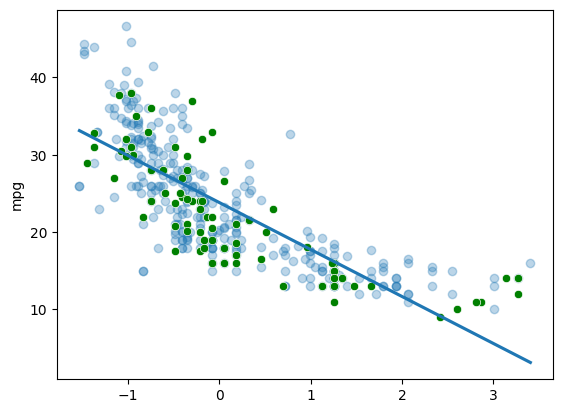

In [ ]:
sns.regplot(x=X_train[:, 0], y=y_train, ci=None, scatter_kws={'alpha':0.3})
sns.scatterplot(x=X_test[:, 0], y=y_test, color="green") # test set in green

Fit regression with $\tt{mpg} \sim \tt{horsepower} + \tt{horsepower}^2$

In [ ]:
reg2 = LinearRegression().fit(X_train[:, 0:2], y_train) # selects the first two columns of

# training and test scores
r2_train = reg2.score(X_train[:, 0:2],  y_train)
r2_test = reg2.score(X_test[:, 0:2],  y_test)

r2_train, r2_test

(0.6829732428525157, 0.684927877666374)

In [ ]:
reg2.coef_

array([-18.32926446,  12.4560456 ])

Fit regression with $\tt{mpg} \sim \tt{horsepower} + \tt{horsepower}^2 + \tt{horsepower}^3$

In [ ]:
reg3 = LinearRegression().fit(X_train, y_train) # We are training another linear regression model (reg3) with all features

# training and test scores
r2_train = reg3.score(X_train,  y_train)
r2_test = reg3.score(X_test,  y_test)

r2_train, r2_test

(0.6843960099951697, 0.6833137118798915)

In [ ]:
reg3.coef_

array([-24.11107403,  24.50679392,  -6.4538901 ])

## Cross-Validation

In [ ]:
# simple code to use Cross vlaidation
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

model = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, Y, cv=cv) # trains the model 5 times, each time leaving out one fold for testing, and returns the performance scores.
print("Cross-validation scores:", scores)
print("Average score:", scores.mean())


Cross-validation scores: [0.63832178 0.56516498 0.73265198 0.79484828 0.6372534 ]
Average score: 0.6736480860582987


In [ ]:


model = LinearRegression()
cv = LeaveOneOut();  # sets up LOOCV

scores = cross_val_score(model, X, Y, cv=cv);  # trains the model once per data point
#print("LOOCV scores:", scores)
#print("Average LOOCV score:", scores.mean())


### Leave-One-Out

##without scaling

In [ ]:
cv = LeaveOneOut()
# note that we are not doing scaling here
y_pred = cross_val_predict(reg, X, Y, cv=cv) # predicts each point’s value using LOOCV to see how well the model performs.

In [ ]:
r2_score(Y, y_pred)

0.6817953805293895

### with scaling

In [ ]:
# with scaling (manually applying LOOCV)
kf = KFold(n_splits = Y.shape[0]) # This is  Leave-One-Out CV, because the number of folds equals the number of samples.
kf.get_n_splits(X)

392

In [ ]:
# This code performs Leave-One-Out cross-validation with scaling,
# training a Linear Regression on each fold and collecting predictions for every sample in pred.

pred = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X.values[train_index], X.values[test_index]
  y_train = Y.values[train_index]
  scaler = StandardScaler() # creates the scaler
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  reg = LinearRegression().fit(X_train, y_train)
  pred.append(reg.predict(X_test))

In [ ]:
r2_score(Y, pred)

0.6817953805293939



```
# This is formatted as code
```

## K fold cross-validation

In [ ]:
# with scaling
kf = KFold(n_splits = 10, random_state = 8675309, shuffle = True)
kf.get_n_splits(X)

10

In [ ]:
r2s = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X.values[train_index], X.values[test_index]
  y_train, y_test = Y.values[train_index], Y.values[test_index]
  scaler = StandardScaler() # creates the scaler
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  reg = LinearRegression().fit(X_train, y_train)
  y_test_hat = reg.predict(X_test)
  r2 = r2_score(y_test, y_test_hat)
  r2s.append(r2)

In [ ]:
np.mean(r2s)

np.float64(0.6664241895486993)

## Regularized regression (L2)

RidgeCV automatically finds the best hyper
parameters for ridge regularized logistic regression (L2). In this case the only parameter is the regularization strength.

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

### wrong way: without scaling

In [ ]:
X = auto.iloc[:, 1:].values # ignore 0th column
Y = auto.iloc[:, 0].values
X.shape, Y.shape

((392, 3), (392,))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=8675309)
# cross-validation with the training set
ridge = RidgeCV(cv=10).fit(x_train, y_train)

In [ ]:
ridge.alpha_

np.float64(10.0)

In [ ]:
ridge.score(x_test, y_test)

0.7261392871354069

### with scaling

In [ ]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [ ]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
ridge.alpha_

np.float64(0.1)

In [ ]:
ridge.score(X_test, y_test)

0.72324320900538

In [ ]:
ridge = Ridge(alpha=1).fit(X_train, y_train)
ridge.score(X_test, y_test)

0.7195500176911181

This is still not perfect. Why?

### Better but more complicated

score_given_alpha:


1. Splits the data into k folds, scales each training set, and trains a Ridge regression with a given alpha.

2. Predicts on the test fold and computes the R² score for each fold.

3. Returns the average R² across all folds as the model’s performance.

In [ ]:
def score_given_alpha(x: np.array,
                      y: np.array,
                      kfold: KFold,
                      alpha: float) -> float:
  """Run a ridge regression with k-fold cross validation and a given penalty
  term (alpha).

  Arguments:
    x (np.array): An array with shape (n, p) containing the attributes.
    y (np.array): An array with shape (n, ) containing the targets.
    kfold (KFold): An object of class KFold.
    alpha (float): The penalty term in the ridge regression.

  Returns:
    The average R^2 (test) across the k-folds.
  """

  # Storage for the R^2 values.
  r2s = []

  # Loop over the k-folds.
  for train_index, test_index in kfold.split(x):
    # Split the data between training and test
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create the scaler using the training data.
    scaler = StandardScaler()
    scaler.fit(x_train)

    # Scale the train/test data.
    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)

    # Run ridge regression with a given alpha.
    reg = Ridge(alpha=alpha).fit(X_train, y_train)

    # Predict on test and determine R^2 (test).
    # Alternatively, you can use:
    #   r2 = reg.score(X_test, y_test)]
    y_test_hat = reg.predict(X_test)
    r2 = r2_score(y_test, y_test_hat)
    r2s.append(r2)

  # Return the mean R^2 across all the folds.
  return np.mean(r2s)

In [ ]:

#This function, find_best_score, builds on the previous score_given_alpha function
def find_best_score(x: np.array,
                    y: np.array,
                    n_splits: int = 10,
                    random_state: int = 8675309,
                    alphas: np.array = [0.001, 0.01, 0.1, 1, 10, 100]) -> tuple:
  """Find the best alpha in a ridge regression.

  Arguments:
    x (np.array): An array with shape (n, p) containing the attributes.
    y (np.array): An array with shape (n, ) containing the targets.
    n_splits (int): The number of folds in the k-fold (default: 10).
    random_state (int): The seed to use in the cv (default: 8675309).
    alpha (np.array): The penalty term in the ridge regression (default:
      [0.001, 0.01, 0.1, 1, 10, 100]).

  """

  # Initial states for best_alpha and best_score.
  best_alpha = alphas[0]
  best_score = 0

  # Create KFold splitss.
  kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
  kf.get_n_splits(x)

  # Loop over the alphas.
  for alpha in alphas:
    # Determine the R^2 (test) for the current alpha.
    score = score_given_alpha(x, y, kf, alpha)

    # If new score is better than current score, then update the values.
    if score > best_score:
      best_score = score
      best_alpha = alpha

  # Return the best_score and best_alpha from the loop.
  return best_score, best_alpha

In [ ]:
best_score, best_alpha = find_best_score(x_train, y_train)
best_score, best_alpha

(np.float64(0.6642457282136874), 1)

In [ ]:
ridge = Ridge(alpha = best_alpha).fit(X_train, y_train)
ridge.score(X_test, y_test)

0.7195500176911181

In [ ]:
ridge.coef_

array([-11.59602077,   0.43043467,   5.61166636])

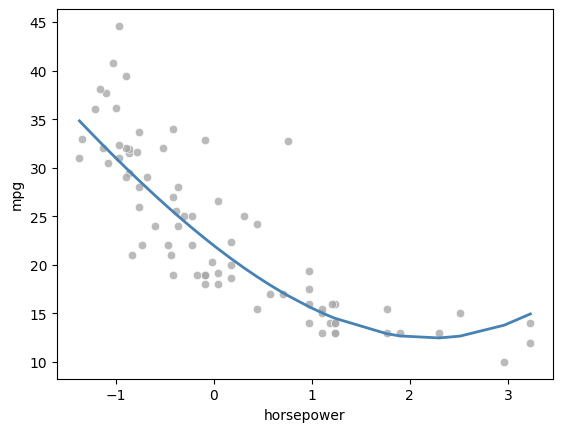

In [ ]:
def plot_ridge(x: np.array,
               y: np.array,
               ridge: Ridge,
               point_color: str = 'darkgray',
               point_alpha: float = 0.8,
               line_color: str = 'steelblue',
               xlab: str = 'horsepower',
               ylab: str = 'mpg') -> None:
  """Plot the observed values and fitted line from a ridge regression.

  Arguments:
    x (np.array): Array of shape (n, p). The first column will contain
      'horsepower'.
    y (np.array): Array of shape (n, ).
    ridge (Ridge): The ridge regression fitted on training data.
    point_color (str): Color of the points (default: 'darkgray').
    point_alpha (float): Alpha value of the points (default: 0.8).
    line_color (str): Color of fitted line.
    xlab (str): Label for the x-axis (default: 'horsepower').
    ylab (str): Label for the y-axis (default: 'mpg'):

  Returns: Nothing
  """

  # Add observe values to a scatter plot.
  sns.scatterplot(x=x[:, 0], y=y, color=point_color, alpha=point_alpha)

  # Add predicted line.
  sns.lineplot(x=x[:, 0], y=ridge.predict(x), color=line_color, linewidth=2)

  # Add x- and y-axes labels.
  plt.xlabel(xlab)
  plt.ylabel(ylab)

plot_ridge(X_test, y_test, ridge)

## Confidence interval for test $R^2$ with repeated experiments

In [ ]:
scores = []
for i in range(50):
  # Split the data into train/test using a new seed for each iteration.
  x_train, x_test, y_train, y_test = train_test_split(
      X, Y, test_size=0.2, random_state=i)

  # We drop the R^2 since this we're only determining alpha with the training.
  _, alpha = find_best_score(x_train, y_train, random_state = i)

  # Make the scaler in this loop.
  scaler = StandardScaler()
  scaler.fit(x_train)

  # Scale training and test.
  X_train = scaler.transform(x_train)
  X_test = scaler.transform(x_test)

  # Fit ridge regression with the best alpha and store the R^2 (test).
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)
  scores.append(ridge.score(X_test, y_test))

In [ ]:
np.array(scores)

In [ ]:
np.quantile(scores, q = 0.025), np.quantile(scores, q = 0.975)

## Lab:
Consider a model that predicts *mpg* as a function of a polynomial regression of degree 6 of *horsepower*. Use Lasso (L1 penalty) to fit the best model. Use cross-validation to find the best regularization parameter.

* What is the final formula and plot the results?
* Which are the non-zero coefficients?
* Give an assesment of the $R^2$ value with an interpretation and confidence intervals.
* Suppose you are trying to find the best degree polynomial. What would you do differently if you were using ridge regression?

## statsmodels.api

When doing simple analysis with linear regression, the statsmodels package has a nicer (more R-like) interface. It also gives a more readable summary of the output.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

auto_lm = smf.glm(
    formula = 'mpg ~ horsepower + I(horsepower**2)',
    data = auto,
    family = sm.families.Gaussian()).fit()

print(auto_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      389
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          19.131
Method:                          IRLS   Log-Likelihood:                -1133.2
Date:                Mon, 27 Oct 2025   Deviance:                       7442.0
Time:                        00:41:41   Pearson chi2:                 7.44e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8874
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             56.9001      1